In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new2 import Fingerprint, Fingerprint_viz, graph_dataset, null_collate, Graph, Logger, time_to_str


In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 18
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  1128
number of successfully processed smiles:  1128


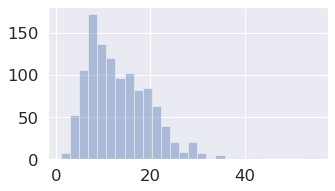

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

epochs = 800
batch_size =100

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
K = 3
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
smiles_dict = graph_dict(smiles_list, label_list=label_list, filename=filename)


graph dicts loaded from ../data/delaney-processed.pkl


In [7]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

batch size:  101


In [8]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
# train_fold = []
# valid_fold = []
# for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
#     train_fold.append(train_idx)
#     valid_fold.append(valid_idx)
    
# avoiding the last batch has too few samples by slightly tune the batch_size
# while (len(train_fold[0]) % batch_size) / batch_size <0.8:
#     batch_size +=1
# print("batch size: ", batch_size)

In [9]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1816455
preprocess.0.linear.weight torch.Size([200, 39])
preprocess.0.linear.bias torch.Size([200])
preprocess.0.bn.weight torch.Size([200])
preprocess.0.bn.bias torch.Size([200])
encoder.0.linear.weight torch.Size([200, 49])
encoder.0.linear.bias torch.Size([200])
encoder.0.bn.weight torch.Size([200])
encoder.0.bn.bias torch.Size([200])
align.weight torch.Size([1, 400])
align.bias torch.Size([1])
attend.linear.weight torch.Size([200, 200])
attend.linear.bias torch.Size([200])
attend.bn.weight torch.Size([200])
attend.bn.bias torch.Size([200])
gru.weight_ih torch.Size([600, 200])
gru.weight_hh torch.Size([600, 200])
gru.bias_ih torch.Size([600])
gru.bias_hh torch.Size([600])
propagate.0.align.weight torch.Size([1, 400])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([200, 200])
propagate.0.attend.linear.bias torch.Size([200])
propagate.0.attend.bn.weight torch.Size([200])
propagate.0.attend.bn.bias torch.Size([200])
propagate.0.gru.weight_ih torch.Si

In [10]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, smiles_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(model, smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, smiles_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [11]:
log = Logger()
log.open(f'{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

best ={}
best["train_epoch"] = 0
best["valid_epoch"] = 0
best["train_MSE"] = 8e2
best["valid_MSE"] = 8e2
best["valid_epoch_train"] = 8e2
best["train_epoch_valid"] = 8e2

for epoch in range(800):
    losses = train(model, train_df.smiles.values)
    traine_MAE, train_MSE = eval(model, train_df.smiles.values)
    valid_MAE, valid_MSE = eval(model, valid_df.smiles.values)

    timing = time_to_str((timer() - start), 'min')  
    log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

    if train_MSE < best["train_MSE"]:
        best["train_epoch"] = epoch
        best["train_MSE"] = train_MSE
        best["train_epoch_valid"] = valid_MSE
    if valid_MSE < best["valid_MSE"]:
        best["valid_epoch"] = epoch
        best["valid_MSE"] = valid_MSE
        best["valid_epoch_train"] = train_MSE
        if valid_MSE < 0.35:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+str(epoch)+'.pt')
    if (epoch - best["train_epoch"] >10) and (epoch - best["valid_epoch"] >18):        
        break
print(best["valid_epoch"],best["valid_epoch_train"],best["valid_MSE"])

epoch | loss | train MSE |  valid MSE |  time 
  0   | 5.6986  | 2.9075  | 3.3225  |  0 hr 00 min 
  1   | 1.8499  | 5.0339  | 6.3266  |  0 hr 00 min 
  2   | 1.0304  | 4.8367  | 5.9861  |  0 hr 00 min 
  3   | 0.8274  | 1.2986  | 1.7306  |  0 hr 00 min 
  4   | 0.6325  | 0.6832  | 0.8699  |  0 hr 00 min 
  5   | 0.5996  | 0.4885  | 0.5792  |  0 hr 00 min 
  6   | 0.6299  | 0.4335  | 0.5244  |  0 hr 00 min 
  7   | 0.4674  | 0.4188  | 0.5569  |  0 hr 00 min 
  8   | 0.5149  | 0.4725  | 0.5428  |  0 hr 00 min 
  9   | 0.5367  | 0.4045  | 0.6086  |  0 hr 00 min 
 10   | 0.4777  | 0.3389  | 0.4650  |  0 hr 00 min 
 11   | 0.4074  | 0.3013  | 0.4189  |  0 hr 00 min 
 12   | 0.4609  | 0.3001  | 0.4052  |  0 hr 00 min 
 13   | 0.4416  | 0.2857  | 0.4645  |  0 hr 00 min 
 14   | 0.4283  | 0.2704  | 0.3750  |  0 hr 00 min 
 15   | 0.4450  | 0.2960  | 0.4863  |  0 hr 00 min 
 16   | 0.4615  | 0.2489  | 0.4370  |  0 hr 00 min 
 17   | 0.4055  | 0.2638  | 0.3956  |  0 hr 00 min 
 18   | 0.3808  |

In [12]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+str(best["valid_epoch"])+'.pt')     
# print("best epoch:",best["valid_epoch"],"\n","test MSE:",test_MSE)

# best_model = torch.load('saved_models/model_'+prefix_filename+'_26.pt')     
test_MAE, test_MSE = eval(best_model, test_df.smiles.values)

print("test MSE:",test_MSE)


test MSE: 0.37069413


In [13]:
viz_list = ['CC(C)NC(=O)N1CC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O',
            'O=C(NC(=O)c1c(F)cccc1F)Nc1cc(Cl)c(F)c(Cl)c1F',
            'CC(=O)Oc1ccccc1C(=O)O']
smiles_dict_predict = graph_dict(viz_list)

def eval_viz(model, smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    mol_prediction_list = []
    atom_feature_list = []
    attention_weight_list = []
    mol_feature_list = []
    mol_feature_unbounded_list = []
    
    eval_loader = DataLoader(graph_dataset(smiles_list, smiles_dict_predict),8, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction, atom_feature, mol_feature, attention_weight = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
#         print(mol_index.shape, atom_feature[0].shape, mol_feature[0].shape, attention_weight[0].shape)
#         torch.Size([58]) torch.Size([58, 32]) torch.Size([3, 32]) torch.Size([58, 1])

        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

        mol_prediction_list.append(mol_prediction.cpu().detach().squeeze().numpy())
        atom_feature_list.append(np.stack([atom_feature[k].cpu().detach().numpy() for k in range(K+1)]))
        attention_weight_list.append(np.stack([attention_weight[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_list.append(np.stack([mol_feature[t].cpu().detach().numpy() for t in range(T)]))
#         mol_feature_unbounded_list.append(np.stack([mol_feature_unbounded_viz[t].cpu().detach().numpy() for t in range(T)]))
        
    mol_prediction_array = np.concatenate(mol_prediction_list,axis=0)
    atom_feature_array = np.concatenate(atom_feature_list,axis=1)
    attention_weight_array = np.concatenate(attention_weight_list,axis=1)
    mol_feature_array = np.concatenate(mol_feature_list,axis=1)
#     mol_feature_unbounded_array = np.concatenate(mol_feature_unbounded_list,axis=1)
#     print(mol_prediction_array.shape, atom_feature_array.shape, atom_weight_array.shape, mol_feature_array.shape)
    return mol_prediction_array, atom_feature_array, attention_weight_array, mol_feature_array #, mol_feature_unbounded_array


In [14]:
viz_list[0] in list(train_df.cano_smiles.values)

True

In [15]:
def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list


[[[0.02661008]
  [0.02754861]
  [0.02664279]
  [0.02978057]
  [0.02749963]
  [0.16772062]
  [0.02780417]
  [0.02804213]
  [0.02750061]
  [0.16772062]
  [0.02789873]
  [0.02756125]
  [0.02737415]
  [0.02753194]
  [0.02762855]
  [0.02737415]
  [0.02753194]
  [0.02762855]
  [0.02737415]
  [0.02750623]
  [0.16772062]]

 [[0.04780672]
  [0.04742432]
  [0.04779315]
  [0.04771696]
  [0.04764462]
  [0.04734022]
  [0.04772376]
  [0.0472506 ]
  [0.04764557]
  [0.04734022]
  [0.04766283]
  [0.04757608]
  [0.04778837]
  [0.04769808]
  [0.04766392]
  [0.04778837]
  [0.04769808]
  [0.04766392]
  [0.04778837]
  [0.04764551]
  [0.04734022]]]


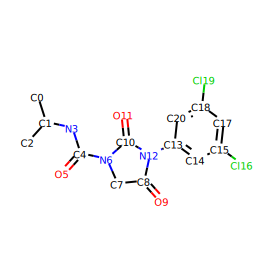

<Figure size 1800x1200 with 0 Axes>

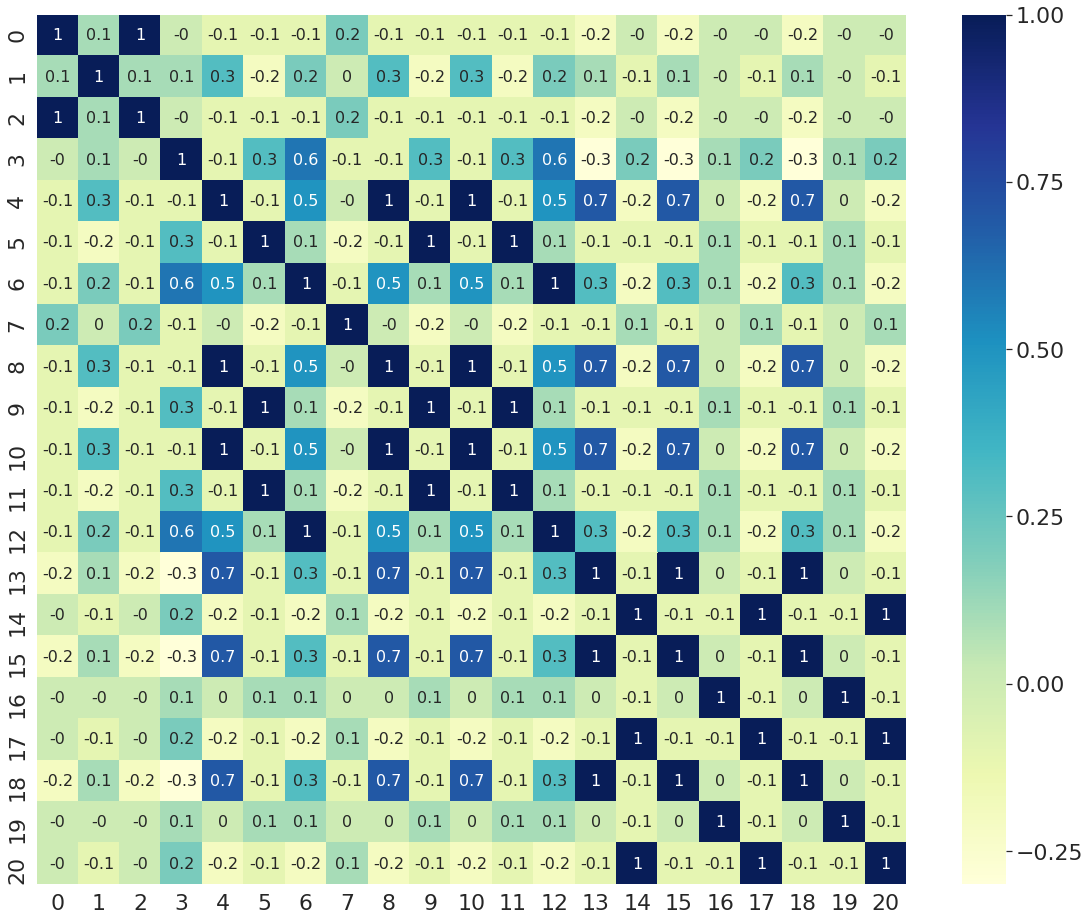

<Figure size 1800x1200 with 0 Axes>

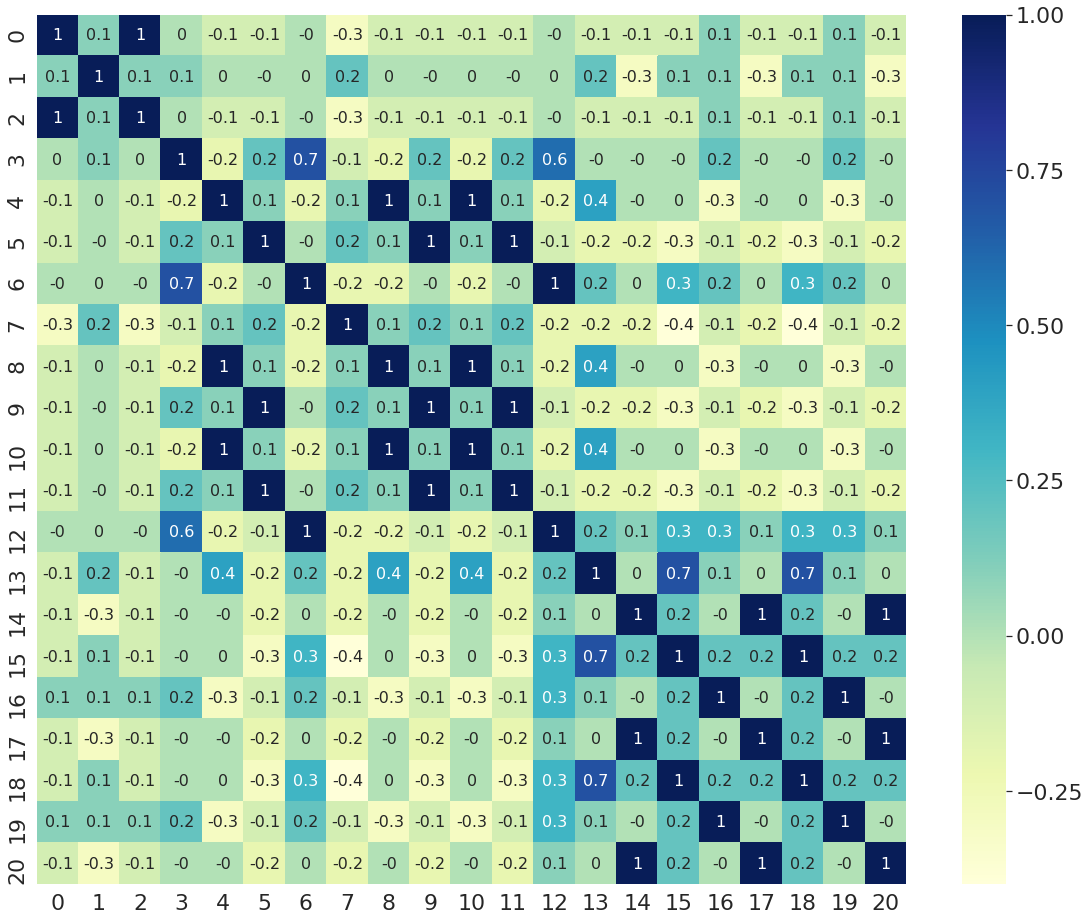

<Figure size 1800x1200 with 0 Axes>

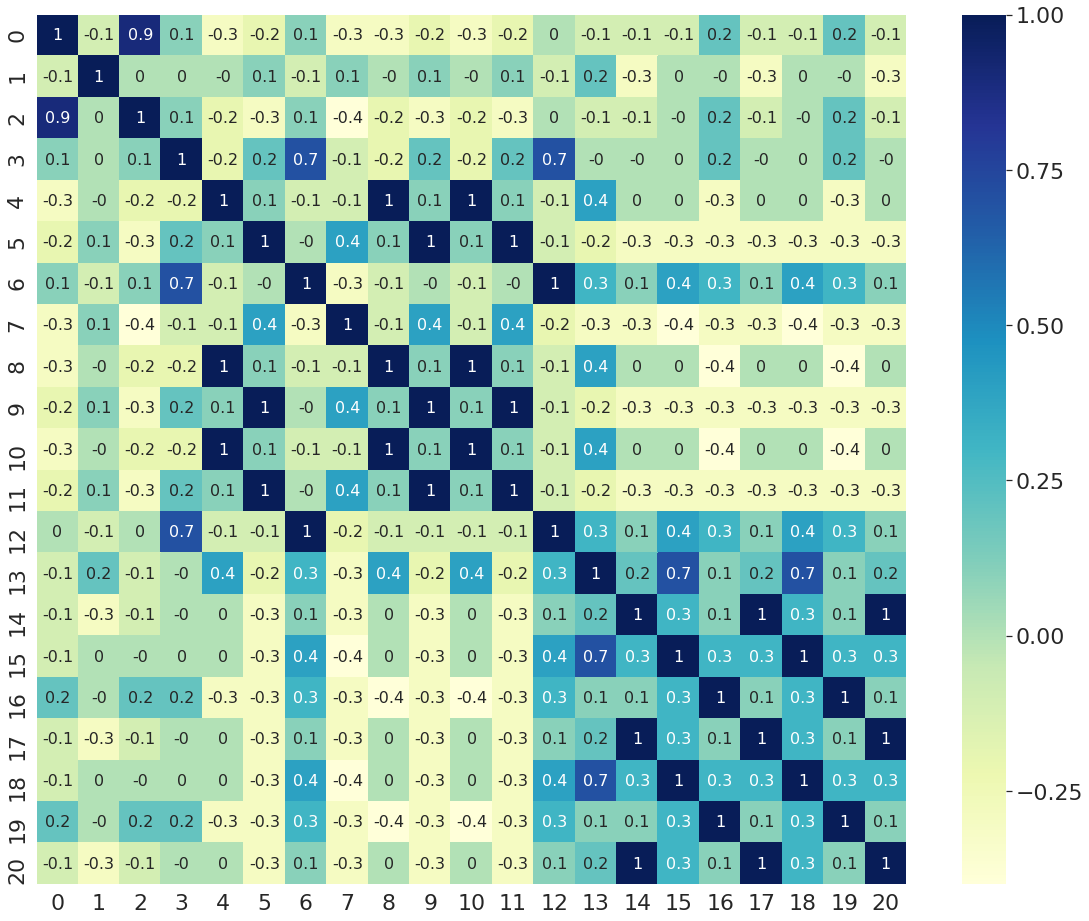

<Figure size 1800x1200 with 0 Axes>

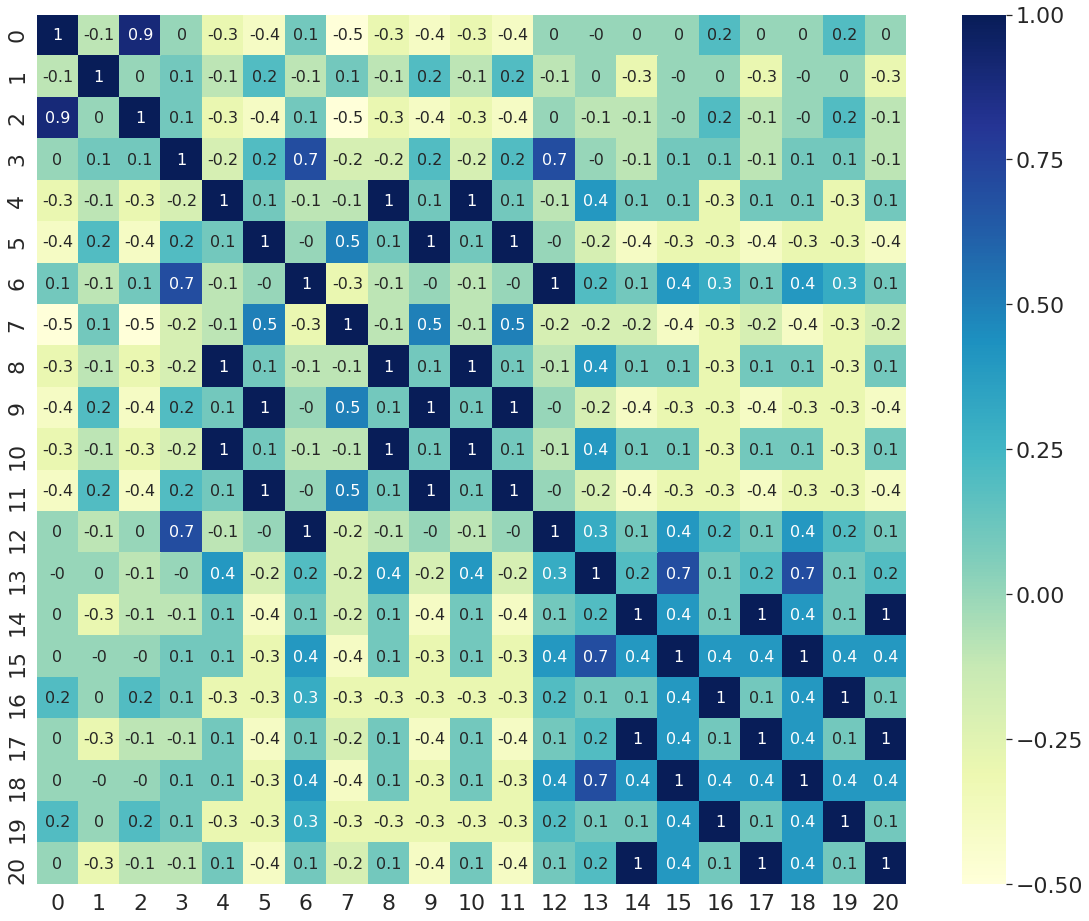

[[[0.362254  ]
  [0.00625894]
  [0.06148245]
  [0.0062555 ]
  [0.362254  ]
  [0.00851837]
  [0.00452701]
  [0.01131781]
  [0.00492377]
  [0.00481696]
  [0.00492377]
  [0.00452701]
  [0.01131781]
  [0.06624085]
  [0.00827274]
  [0.00452219]
  [0.00761529]
  [0.01014085]
  [0.00465206]
  [0.01131781]
  [0.00775007]
  [0.01014085]
  [0.00465206]
  [0.01131781]]

 [[0.04141543]
  [0.04168246]
  [0.04176099]
  [0.0416825 ]
  [0.04141543]
  [0.0417579 ]
  [0.04182283]
  [0.04146215]
  [0.04171942]
  [0.04149248]
  [0.04171942]
  [0.04182283]
  [0.04146215]
  [0.04175425]
  [0.04175448]
  [0.0418075 ]
  [0.04174856]
  [0.04169862]
  [0.04181831]
  [0.04146215]
  [0.04176101]
  [0.04169862]
  [0.04181831]
  [0.04146215]]]


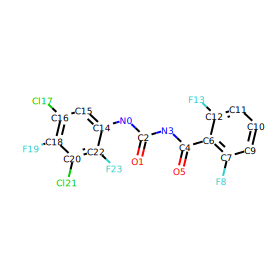

<Figure size 1800x1200 with 0 Axes>

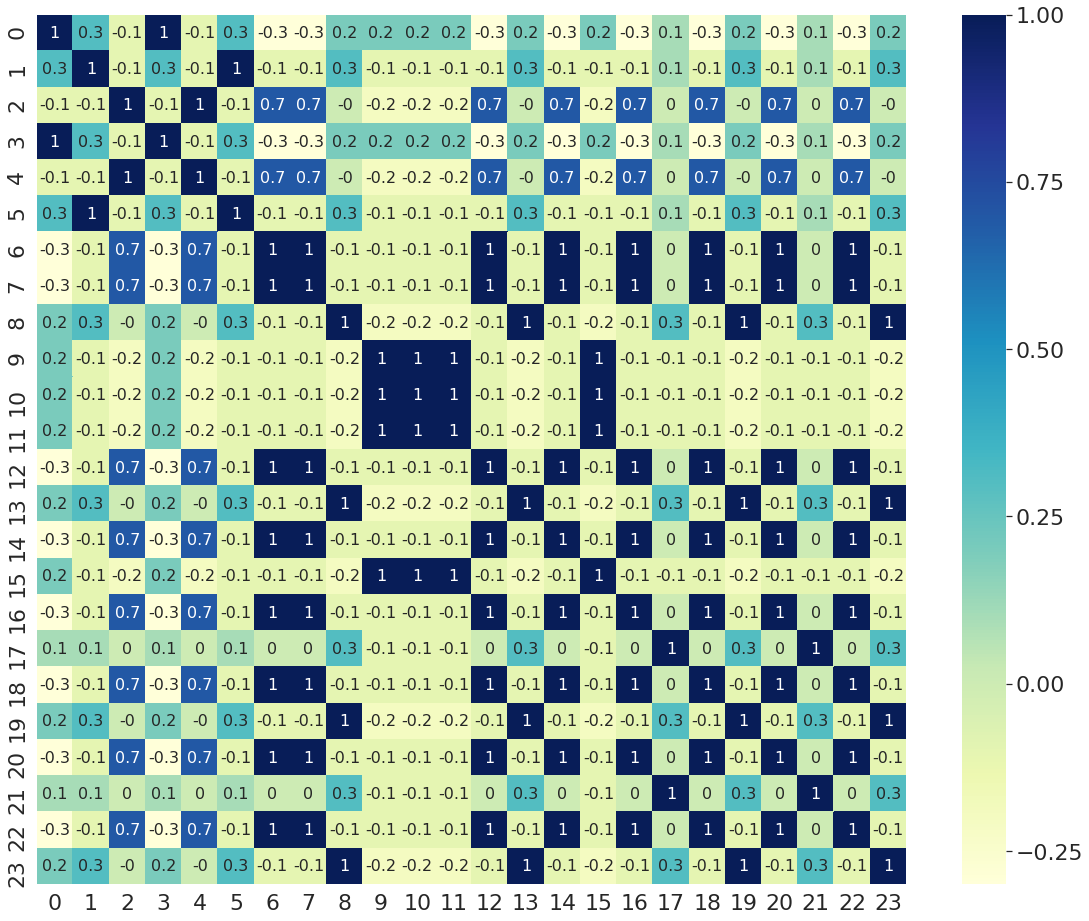

<Figure size 1800x1200 with 0 Axes>

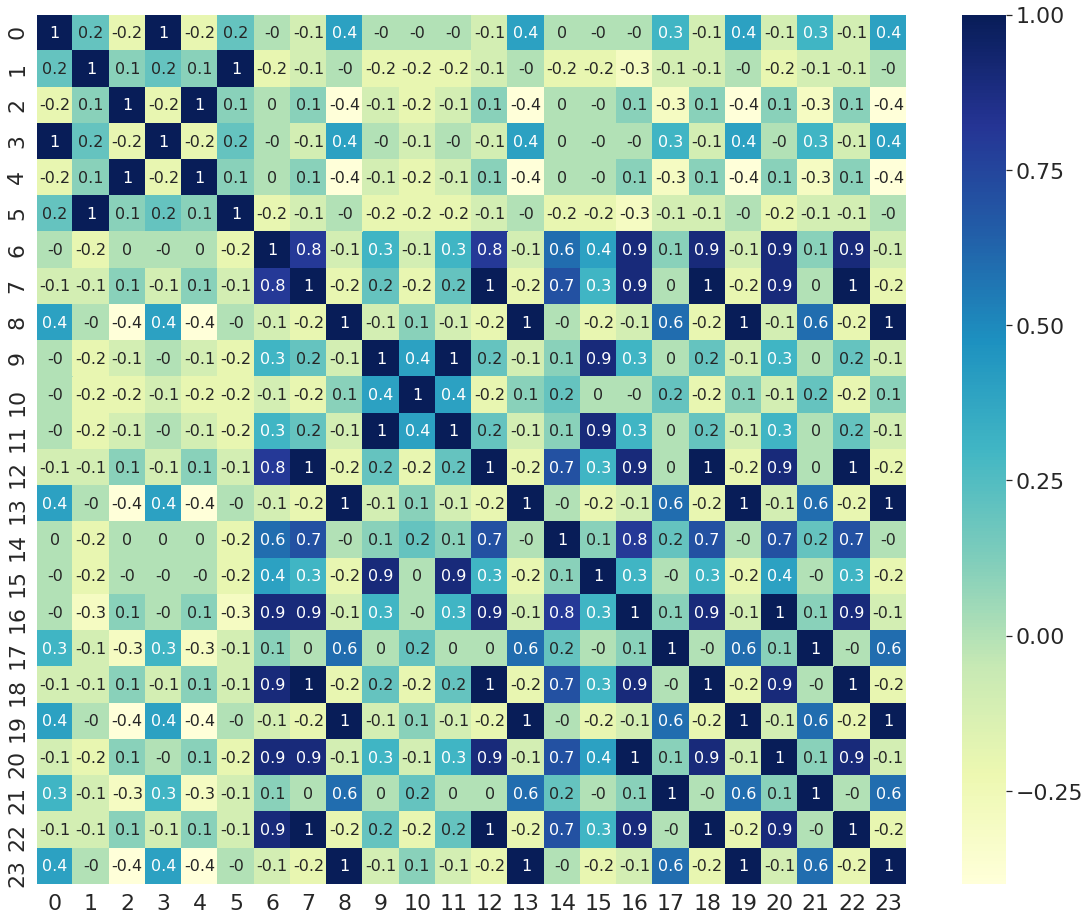

<Figure size 1800x1200 with 0 Axes>

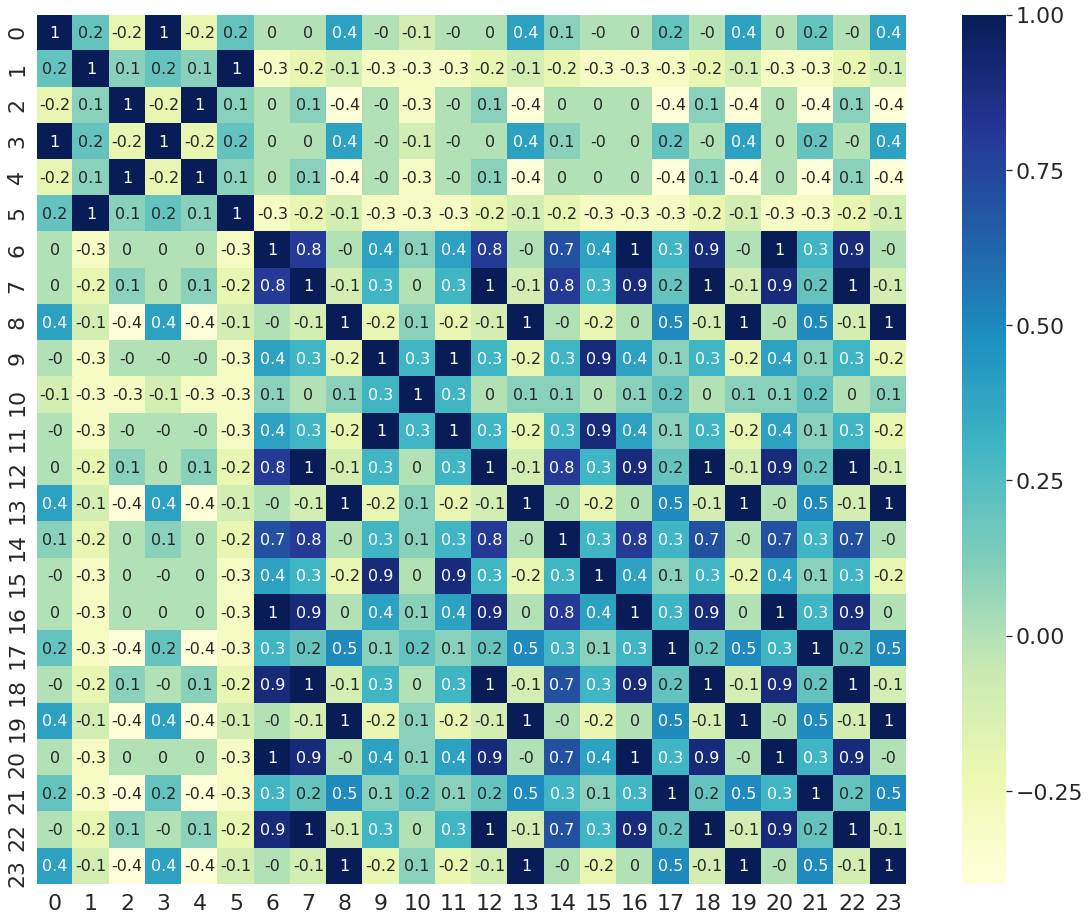

<Figure size 1800x1200 with 0 Axes>

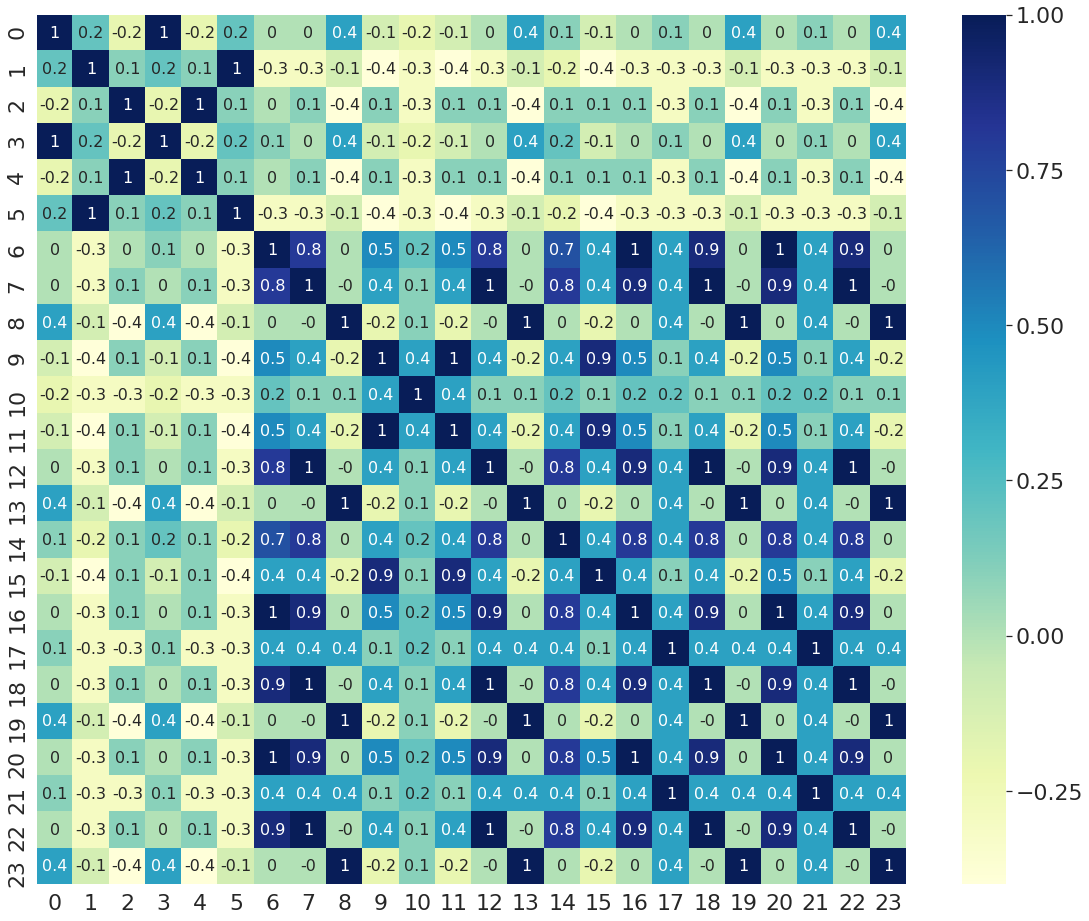

[[[0.05806344]
  [0.06012183]
  [0.13542321]
  [0.06153514]
  [0.06097183]
  [0.05982256]
  [0.05980944]
  [0.05980944]
  [0.05982256]
  [0.06017548]
  [0.05996535]
  [0.13542321]
  [0.12905651]]

 [[0.07718983]
  [0.07706896]
  [0.07660285]
  [0.07717195]
  [0.07682241]
  [0.07716511]
  [0.07674538]
  [0.07674538]
  [0.07716511]
  [0.07720764]
  [0.07709391]
  [0.07660285]
  [0.07641871]]]


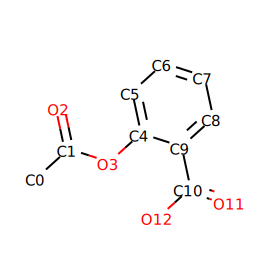

<Figure size 1800x1200 with 0 Axes>

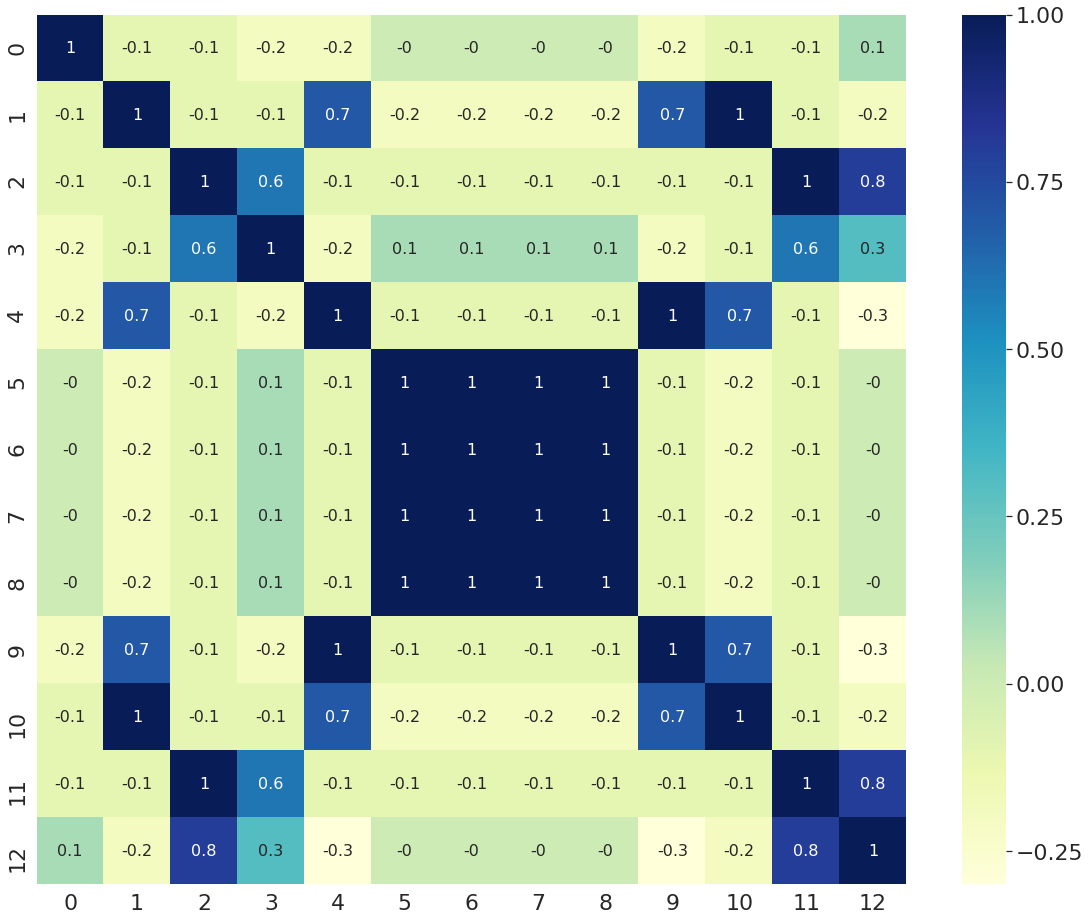

<Figure size 1800x1200 with 0 Axes>

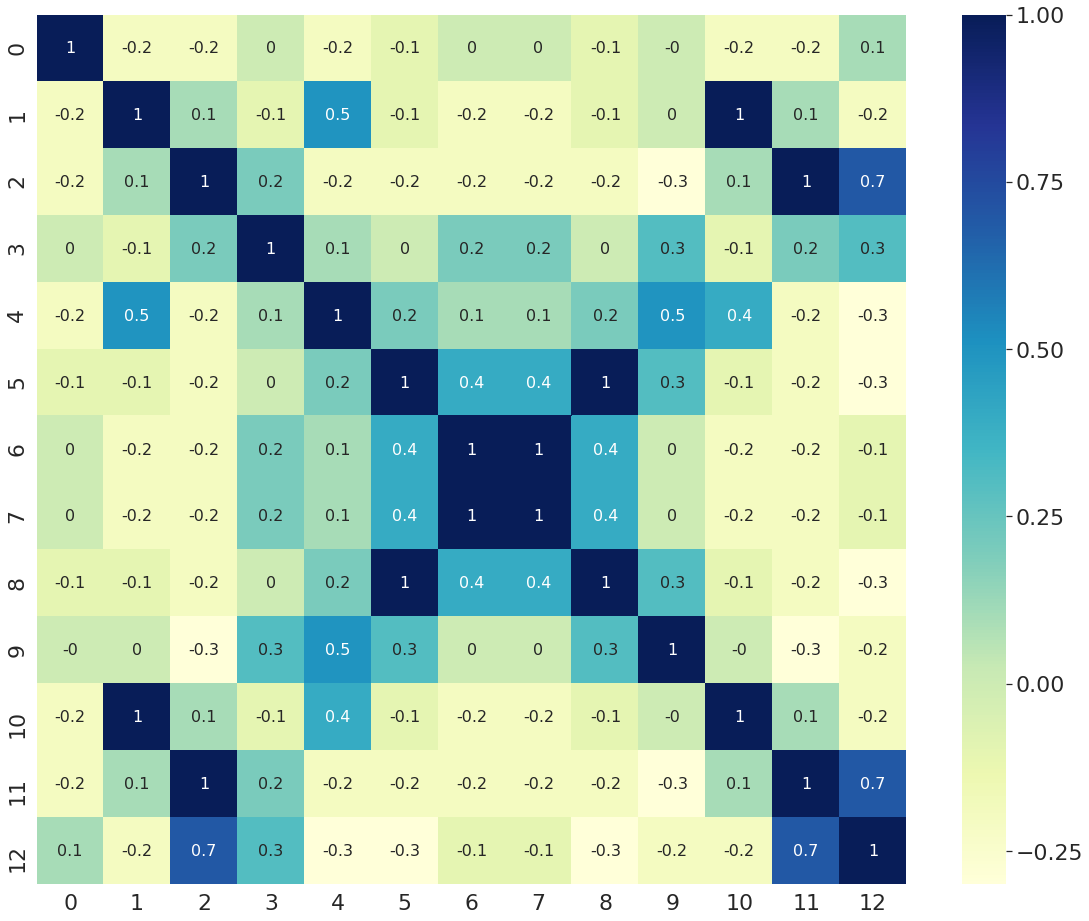

<Figure size 1800x1200 with 0 Axes>

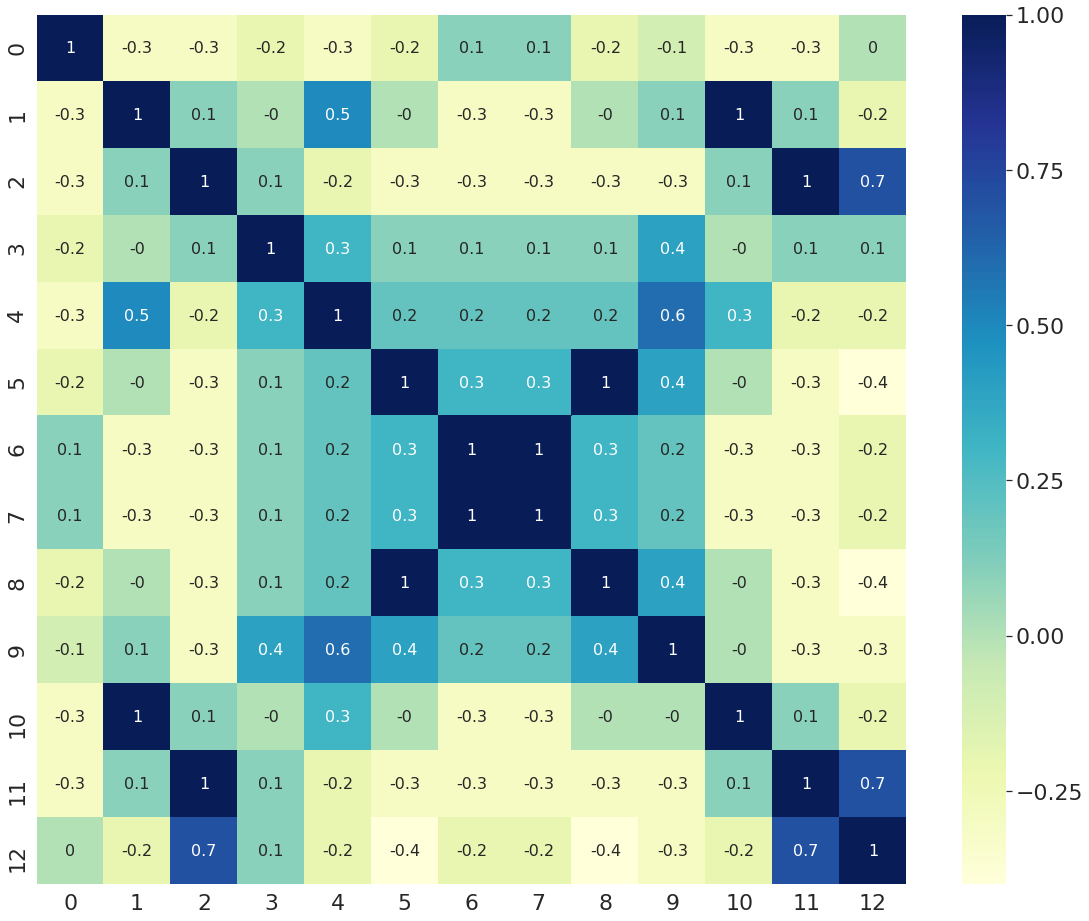

<Figure size 1800x1200 with 0 Axes>

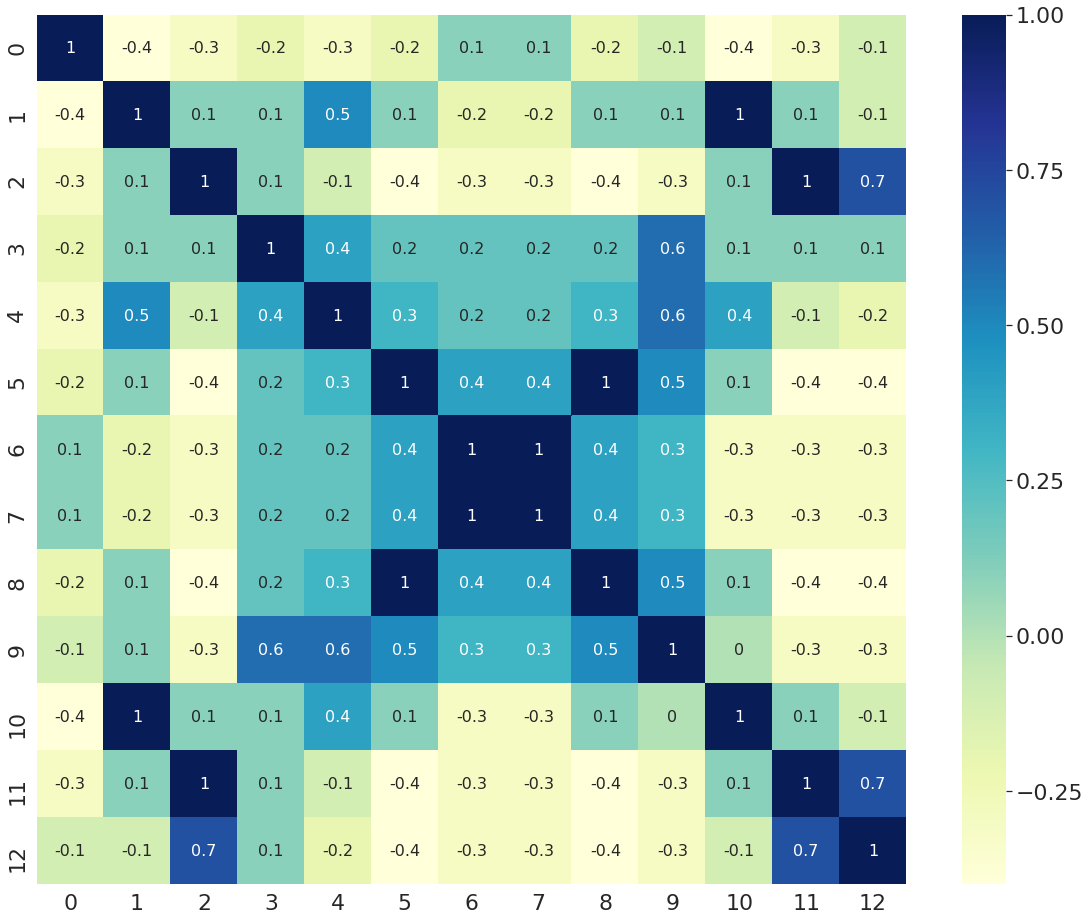

In [19]:
model_viz = Fingerprint_viz(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model_viz.to(device)

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model_viz.load_state_dict(best_model_wts)

mol_prediction_array, atom_feature_array, attention_weight_array, mol_feature_array = eval_viz(model_viz, viz_list)

offset = 0
for i, smiles in enumerate(viz_list):
#     draw molecules in svg format
    mol = Chem.MolFromSmiles(smiles)
    num_atom = Chem.RemoveHs(mol).GetNumAtoms()
    
    mol_prediction = mol_prediction_array[i]
    atom_feature = atom_feature_array[:,offset:offset+num_atom]
    atom_weight = attention_weight_array[:, offset:offset+num_atom]
    mol_feature = mol_feature_array[:, offset:offset+num_atom]
    print(atom_weight)
    offset += num_atom
            
#     reorder for draw
    if i == 0:    
        draw_index = [0,1,2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,10,11]
        feature_reorder = np.stack([atom_feature[:,m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([atom_weight[:,m] for m in np.argsort(draw_index)])
    elif i == 1:
        draw_index = [1,2,3,4,5,6,7,8,9,10,11,12,13,0,14,15,16,17,18,19,20,21,22,23]
        feature_reorder = np.stack([atom_feature[:,m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([atom_weight[:,m] for m in np.argsort(draw_index)])
    else: 
        draw_index = list(range(num_atom))
        feature_reorder = np.stack([atom_feature[:,m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([atom_weight[:,m] for m in np.argsort(draw_index)])
    
    drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
    drawer.SetFontSize(0.56)
    op = drawer.drawOptions()
    for index, re_index in enumerate(draw_index):
        op.atomLabels[index]=mol.GetAtomWithIdx(index).GetSymbol() + str(re_index)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)
    
    intra_mol_correlation = [np.corrcoef(feature_reorder[:,k]) for k in range(K+1)]
    sns.set(font_scale=2)
    
    for k in range(K+1):
        plt.figure(dpi=300)
        fig, ax = plt.subplots(figsize=(20,16))
        mask = np.zeros_like(intra_mol_correlation[k])
        mask[np.triu_indices_from(mask)] = False
        sns.heatmap(np.around(intra_mol_correlation[k],1),cmap="YlGnBu", annot=True, ax=ax, mask=mask, square=True, annot_kws={"size": 16})
    plt.show()
    plt.close()
        

In [17]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best["test_epoch"],"\n","test MSE:",test_MSE)

In [18]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)